## TODO:

- Change to not pick a single reference isoform


- Need another metric as well as pct ID to take into account gaps:
    - gaps in domain alignment 
    

In [1]:
import pandas as pd
from Bio import Align

from data_loading import load_valid_isoform_clones

In [21]:
doms = pd.read_excel('../../data/TF_reg_domain_2019-08-13.xlsx',
                   sheet_name='Sheet1')

In [23]:
doms = pd.read_excel('../../data/TF_reg_domain_2019-08-13.xlsx',
                   sheet_name='Sheet1')
doms = (doms.loc[:, ['symbol', 'Domain type', 'Domain sequence', 'aa position']]
        .rename(columns={'symbol': 'hgnc_gene_symbol',
                         'Domain type': 'type',
                         'Domain sequence': 'aa_seq',
                         'aa position': 'pos'}))
doms = doms.dropna()
doms['aa_seq'] = doms['aa_seq'].str.replace(' ', '')
if doms['hgnc_gene_symbol'].isnull().any():
    raise UserWarning('Missing gene name')
if not doms['hgnc_gene_symbol'].isin(iso['gene']).all():
    raise UserWarning('incorrect gene name')
renaming_dom_type = {'Repression (dimerization)': 'Repression',
                     'Activation/Repression': 'Regulatory',
                     'Regulatory domain': 'Regulatory'}
doms['type'] = doms['type'].map(lambda x: renaming_dom_type.get(x, x))
doms['reg_dom_id'] = (doms['hgnc_gene_symbol'] + 
                      '_' + 
                      (doms.groupby('hgnc_gene_symbol').cumcount() + 1).astype(str))
if doms['reg_dom_id'].duplicated().any():
    raise UserWarning('something went wrong')
doms = doms.set_index('reg_dom_id')

doms['type'].value_counts()

Activation                177
Repression                 85
Predicted repression       81
DNA binding inhibition      5
Regulatory                  2
Name: type, dtype: int64

In [11]:
iso = load_valid_isoform_clones()

In [5]:
# What should the output look like?

# Two tables: 
#   1. remapped domains to all isoform which is good match, containing start / end
#   2. one row for each domain and each isoform with how much of domain is in there

In [30]:
doms.head()

,hgnc_gene_symbol,type,aa_seq,pos
reg_dom_id,,,,
CREB3L3_1,CREB3L3,Activation,MNTDLAAGKMASAACSMDPIDSFELLDLLFDRQDGILRHVELGEGW...,1-149 (Q68CJ9-1)
ELK3_1,ELK3,Activation,SLTPAFFTAQTPNGLLLTPSPLLSSIHFWSSLSPVAPLSPARLQGP...,325-407 (P41970-1)
ELK3_2,ELK3,Repression,NPPDAFKAIKTEKLEEPPEDSPPVEEVRTVIRFVTNK,153-189 (P41970-1)
FOXO3_1,FOXO3,Activation,NLNDGLTENLMDDLLDNITLPPSQPSPTGGLMQRSSSFPYTTKGSG...,377-673 (O43524-1)
GATA1_1,GATA1,Activation,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,1-83 (P15976-1)


In [53]:
def num_aa_id(algn):
    a = [algn.target[i] for start, stop in algn.aligned[0] for i in range(start, stop)]
    b = [algn.query[i] for start, stop in algn.aligned[1] for i in range(start, stop)]
    if len(a) != len(b):
        raise UserWarning('Something went wrong')
    return sum(l_a == l_b for l_a, l_b in zip(a, b))


aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
aligner.target_end_gap_score = 0.0
aligner.query_end_gap_score = 0.0


remapped = []
domain_aligments = {}
PCT_ID_CUTOFF = 95
for i, domain in doms.iterrows():
    is_gene_match = (iso['gene'] == domain['hgnc_gene_symbol'])
    is_perfect_match = is_gene_match & iso['aa_seq'].str.contains(domain['aa_seq'])
    if is_perfect_match.any():
        for __i_iso, row in iso.loc[is_perfect_match, :].iterrows():
            start = row['aa_seq'].index(domain['aa_seq']) + 1
            remapped.append((domain.name,
                                     row['gene'],
                                     row['clone_acc'],
                                     start,
                                     start + (len(domain['aa_seq']) - 1),
                                     100,
                                     0))
    else:
        for __i_iso, row in iso.loc[is_gene_match, :].iterrows():
            alignment = aligner.align(row['aa_seq'], domain['aa_seq'])[0]
            pct_id = 100 * (num_aa_id(alignment) / len(domain['aa_seq']))
            if pct_id >= PCT_ID_CUTOFF:
                domain_aligments[(row['clone_acc'], domain.name)]  = alignment
                n_gaps = alignment.__str__().split()[0].count('-')
                start = alignment.aligned[0][0][0] + 1
                stop = alignment.aligned[0][-1][1]
                remapped.append((domain.name,
                                         domain['hgnc_gene_symbol'],
                                         row['clone_acc'],
                                         start,
                                         stop,
                                         pct_id,
                                         n_gaps))
remapped = pd.DataFrame(remapped, columns=['reg_dom_id',
                                                           'gene', 
                                                           'clone_acc', 
                                                           'start', 
                                                           'end', 
                                                           'pct_match',
                                                           'n_gaps_in_iso_align'])

In [70]:
remapped.sort_values('pct_match').head(20)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align,new_length,old_length,length_diff
361,ZNF415_1,ZNF415,ZNF415|4/4|06H04,6,45,95.238095,0,40,42,2
362,ZNF415_2,ZNF415,ZNF415|2/4|06C05,6,45,97.560976,0,40,41,1
363,ZNF415_2,ZNF415,ZNF415|3/4|06A06,6,45,97.560976,0,40,41,1
364,ZNF415_2,ZNF415,ZNF415|4/4|06H04,6,45,97.560976,0,40,41,1
41,ZNF317_2,ZNF317,ZNF317|1/2|09H11,57,96,97.560976,0,40,41,1
359,ZNF415_1,ZNF415,ZNF415|2/4|06C05,5,45,97.619048,0,41,42,1
360,ZNF415_1,ZNF415,ZNF415|3/4|06A06,5,45,97.619048,0,41,42,1
213,ZNF101_1,ZNF101,ZNF101|2/2|04B05,3,44,97.619048,0,42,42,0
140,NANOG_2,NANOG,NANOG|2/2|01H08,1,95,97.894737,0,95,95,0
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8,414,422,8


In [55]:
remapped.sort_values('n_gaps_in_iso_align', ascending=False).head(20)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8
0,CREB3L3_1,CREB3L3,CREB3L3|1/2|07C03,1,148,99.328859,1
46,ZNF607_1,ZNF607,ZNF607|1/2|04H08,7,66,98.360656,1
170,RORA_1,RORA,RORA|2/2|05H06,217,329,99.122807,1
401,HNF4A_2,HNF4A,HNF4A|2/6|10H07,346,452,100.000000,0
395,GATA2_1,GATA2,GATA2|3/4|12A02,1,70,100.000000,0
396,GATA2_2,GATA2,GATA2|2/4|12D02,410,480,100.000000,0
397,GATA2_2,GATA2,GATA2|3/4|12A02,396,466,100.000000,0
398,HNF4A_1,HNF4A,HNF4A|1/6|10D08,1,50,100.000000,0
399,HNF4A_1,HNF4A,HNF4A|4/6|10A10,1,50,100.000000,0


In [58]:
(remapped.loc[remapped['pct_match'] == 100, 'reg_dom_id'].nunique(), 
 remapped.loc[remapped['pct_match'] >= 95, 'reg_dom_id'].nunique(),
 doms.shape[0])

(309, 322, 350)

In [68]:
# check length of original domain against length of remapped domain..
remapped['new_length'] = ((remapped['end'] - remapped['start']) + 1)
remapped['old_length'] = remapped['reg_dom_id'].map(doms['aa_seq'].str.len())
remapped['length_diff'] = (remapped['new_length'] - remapped['old_length']).abs()
remapped.sort_values('length_diff', ascending=False).head(5)

,reg_dom_id,gene,clone_acc,start,end,pct_match,n_gaps_in_iso_align,new_length,old_length,length_diff
7,MEF2A_1,MEF2A,MEF2A|1/2|12D08,86,499,98.104265,8,414,422,8
361,ZNF415_1,ZNF415,ZNF415|4/4|06H04,6,45,95.238095,0,40,42,2
0,CREB3L3_1,CREB3L3,CREB3L3|1/2|07C03,1,148,99.328859,1,148,149,1
364,ZNF415_2,ZNF415,ZNF415|4/4|06H04,6,45,97.560976,0,40,41,1
46,ZNF607_1,ZNF607,ZNF607|1/2|04H08,7,66,98.360656,1,60,61,1


In [ ]:
# table of domain changes
# take case where domain is largest
# alignment?

Help on method set_position in module matplotlib.spines:

set_position(position) method of matplotlib.spines.Spine instance
    Set the position of the spine.
    
    Spine position is specified by a 2 tuple of (position type,
    amount). The position types are:
    
    * 'outward' : place the spine out from the data area by the
      specified number of points. (Negative values specify placing the
      spine inward.)
    
    * 'axes' : place the spine at the specified Axes coordinate (from
      0.0-1.0).
    
    * 'data' : place the spine at the specified data coordinate.
    
    Additionally, shorthand notations define a special positions:
    
    * 'center' -> ('axes',0.5)
    * 'zero' -> ('data', 0.0)



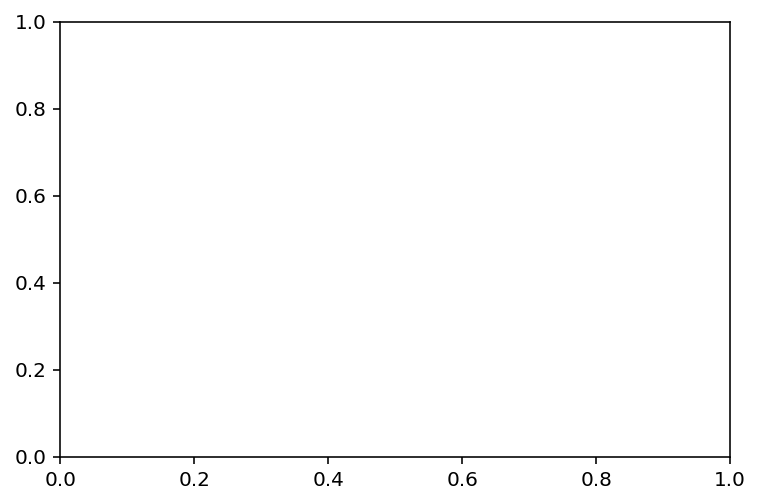

In [177]:
help(plt.gca().spines['bottom'].set_position)

In [225]:
dbd = pd.read_csv('../../data/190914_6K_affect_of_mapped_uniprot_dbds_with_flank_for_juan.tsv',
                 sep='\t')
dbd.head()

,gene,isoacc,dbd_pfam_acc,dbd_name,dom_start_idx,dom_end_idx,prot_cmp_block_string,prot_cmp_string,dom_len,num_match,%AA_preserved_denom_dom_len
0,LHX6,LHX6|1/4|03D01,PF00046,Homeodomain,234.0,320.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
1,LHX6,LHX6|4/4|11G11,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
2,LHX6,LHX6|3/4|02B12,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
3,LHX6,LHX6|2/4|02C12,PF00046,Homeodomain,205.0,291.0,M,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,87,100.000000
4,LHX8,LHX8|1/2|12A10,PF00046,Homeodomain,211.0,297.0,MR,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,87,86,98.850575


In [226]:
dbd.dbd_name.unique()

array(['Homeodomain', 'T-box', 'GATA', 'bHLH', 'E2F_TDP', 'HMG_box',
       'Ets', 'MH1', 'Rel', 'Forkhead', 'ARID/BRIGHT', 'TEA', 'TBP',
       'bZIP', 'WT1', 'RFX', 'HSF', 'IPT/TIG', 'p53', 'IRF',
       'MADS box/SRF-TF', 'Myb/SANT', 'THAP finger', 'CBFD_NFYB_HMF',
       'EBF1', 'POU', 'SAND', 'PAX', 'STAT', 'AP-2', 'CP2', 'Runt',
       'Pipsqueak'], dtype=object)

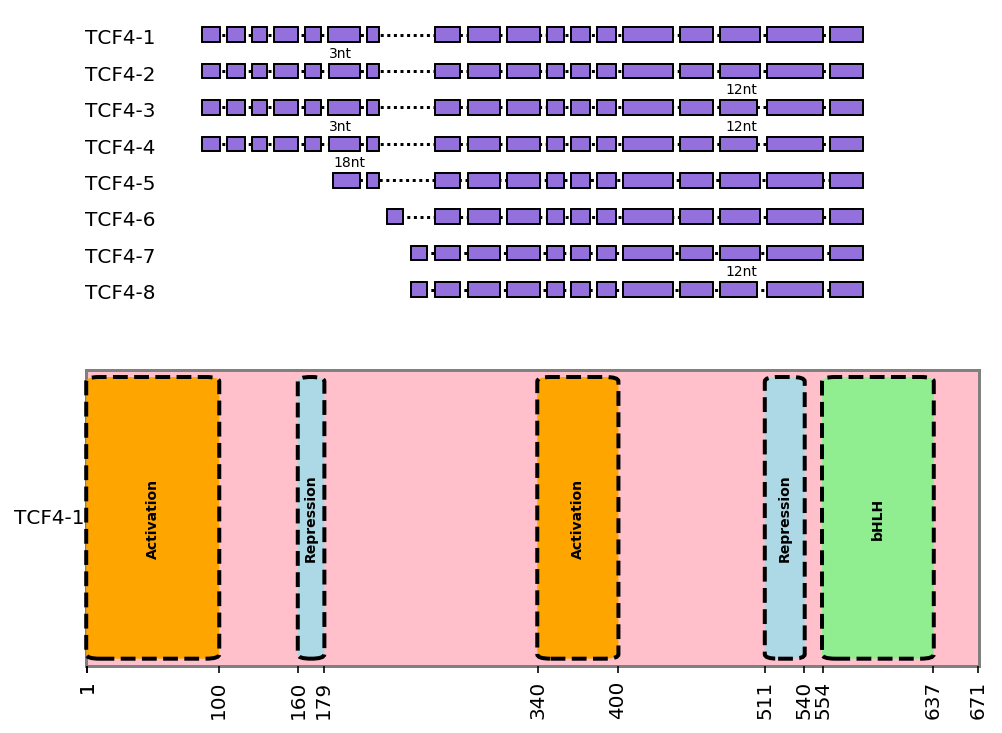

In [252]:
# make a function to visualize the domains
from matplotlib import pyplot as plt
from matplotlib import patches

from plotting import isoform_box_and_line_drawing, isoform_display_name


def domain_fig(seq_len,
               domain_pos,
               domain_labels=None,
               protein_name=None,
               colors=None,
               protein_color='pink',
               ax=None):
    # deal with overlaps
    # dimensions
    # options to control rotation
    if ax is None:
        ax = plt.gca()
    if colors is None:
        colors = ['orange'] * len(domain_pos)
    ax.set_ylim(0, 1)
    ax.set_xlim(0.5, seq_len + 0.5)
    height = 1
    prot = patches.Rectangle((0.5, 0.5 - height / 2),
                             width=seq_len,
                             height=height,
                             clip_on=False,
                             facecolor=protein_color,
                             edgecolor='grey',
                             linewidth=1.5)
    ax.add_patch(prot)
    if domain_labels is None:
        domain_labels = [''] * len(domain_pos)
    for (start, stop), lab, color in zip(domain_pos, domain_labels, colors):
        ax.add_patch(patches.FancyBboxPatch((start - 0.5, 0.5 - (height * 0.95) / 2),
                                       width=(stop - start) + 1,
                                       height=height*0.95,
                                       clip_on=False,
                                       facecolor=color,
                                       boxstyle='round,pad=0,rounding_size=10',
                                       mutation_aspect=1/seq_len,
                                       edgecolor='black',
                                       linewidth=2,
                                       linestyle='--'
                                      ))
        ax.text(x=start + (stop - start) / 2,
                y=0.5,
                s=lab,
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=7,
                rotation=90,)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.spines['bottom'].set_position(('data', 0.5 - height / 2))
    ax.set_xticks([1] + [i for ij in domain_pos for i in ij] + [seq_len])
    ax.xaxis.set_tick_params(rotation=90)
    
    ax.set_yticks([])
    if protein_name is not None:
        ax.text(x=-0.5,
                y=0.5,
                s=protein_name,
                horizontalalignment='right',
                verticalalignment='center')

    

#iso_id = 'PKNOX1|1/4|11H11'
gene = 'TCF4'
iso_id = iso.loc[iso['gene'] == gene, 'clone_acc'].iloc[0]
#gene = iso_id.split('|')[0]
num_aa = iso.loc[iso['clone_acc'] == iso_id, 'aa_seq'].str.len().values[0]


pos = list(remapped.loc[remapped['clone_acc'] == iso_id, ['start', 'end']].values)
pos += list(dbd.loc[dbd['isoacc'] == iso_id, ['dom_start_idx', 'dom_end_idx']].values)

labs = remapped.loc[remapped['clone_acc'] == iso_id, 'reg_dom_id'].map(doms['type']).to_list()
labs += dbd.loc[dbd['isoacc'] == iso_id, 'dbd_name'].to_list()


dom_colors = {'Activation': 'orange',
              'Repression': 'lightblue',
              'bHLH': 'lightgreen'}
# {k: 'lightgreen' for k in dbd['dbd_name'].unique()}
fig, axes = plt.subplots(2, 1)#sharex=True)
fig.set_size_inches(8, 6)
domain_fig(num_aa, 
           pos, 
           labs,
           colors=[dom_colors.get(lab, 'lightgreen') for lab in labs],
           protein_name=isoform_display_name(iso_id),
           ax=axes[1])
# try plotting next to exon structure
isoform_box_and_line_drawing(gene, 
                             iso.loc[iso['gene'] == gene, 'clone_acc'].unique(),
                             ax=axes[0])
# TCF4 is a difficult example because there are insertions and deletions....
# Get other PFam domains
# check why HEY2|2/2|05C07 gives error
# get the ZF domains